In [10]:
import os
import numpy as np
import cv2
import os
import numpy as np
import cv2
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

from xgboost import XGBClassifier
from collections import Counter
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [19]:
DATASET_PATH = "/kaggle/input/training/Training"
#DATASET_PATH_TEST = "/kaggle/working/Museum_Test"

In [20]:
def image_hash(image):
    """Generate a hash for an image to detect duplicates."""
    return hashlib.md5(image.tobytes()).hexdigest()

In [21]:
def preprocess_images(dataset_path):
    labels = []
    features = []
    brightness_values = []
    edge_densities = []
    seen_hashes = set()  # Track seen images to remove duplicates

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)

        if not os.path.isdir(category_path):
            continue

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)

            # Skip corrupt or unreadable images
            if image is None:
                print(f"Warning: Skipping unreadable image {image_path}")
                continue

            # Resize image
            image = cv2.resize(image, (128, 128))

            # Check for duplicate images
            img_hash = image_hash(image)
            if img_hash in seen_hashes:
                print(f"Skipping duplicate image: {image_path}")
                continue
            seen_hashes.add(img_hash)

            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Compute brightness (normalized)
            brightness = np.mean(image) / 255.0  # Scale to [0,1]
            brightness_values.append(brightness)

            # Compute edge density (normalized)
            edges = cv2.Canny(gray, 100, 200)
            edge_density = np.sum(edges) / (image.size * 255.0)  # Scale to [0,1]
            edge_densities.append(edge_density)

            # Extract features
            color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform").flatten()
            hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

            # Combine all features
            feature_vector = np.hstack([color_hist, lbp, hog_features, brightness, edge_density])
            features.append(feature_vector)

            # Assign label: 0 for Indoor, 1 for Outdoor
            labels.append(0 if category.lower() == "museum-indoor" else 1)

    # Convert lists to numpy arrays
    X = np.array(features)
    y = np.array(labels)

    # Standardize features (for better ML performance)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Print class distribution
    class_counts = Counter(y)
    print("Class distribution:", class_counts)

    return X, y, brightness_values, edge_densities



In [22]:
# Preprocess images and extract features
X, y, brightness_values, edge_densities = preprocess_images(DATASET_PATH)

Skipping duplicate image: /kaggle/input/training/Training/museum-outdoor/00001121.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00001569.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00000289.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00000635.jpg
Class distribution: Counter({1: 4999, 0: 4997})


In [23]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

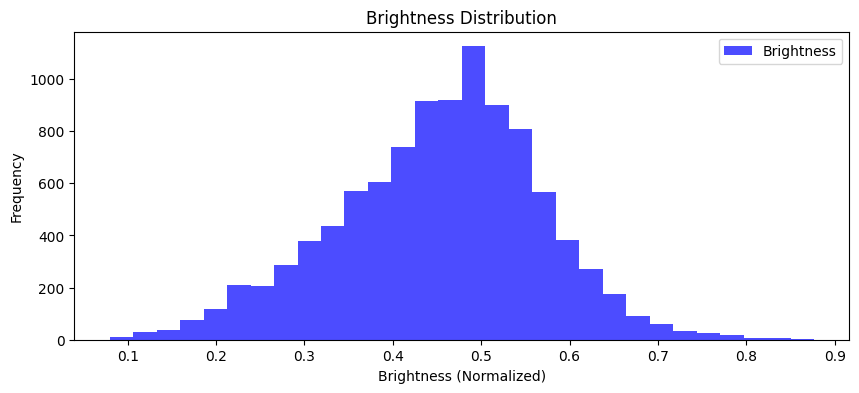

In [24]:
# EDA Visualizations
plt.figure(figsize=(10, 4))
plt.hist(brightness_values, bins=30, color='blue', alpha=0.7, label='Brightness')
plt.xlabel("Brightness (Normalized)")
plt.ylabel("Frequency")
plt.title("Brightness Distribution")
plt.legend()
plt.show()

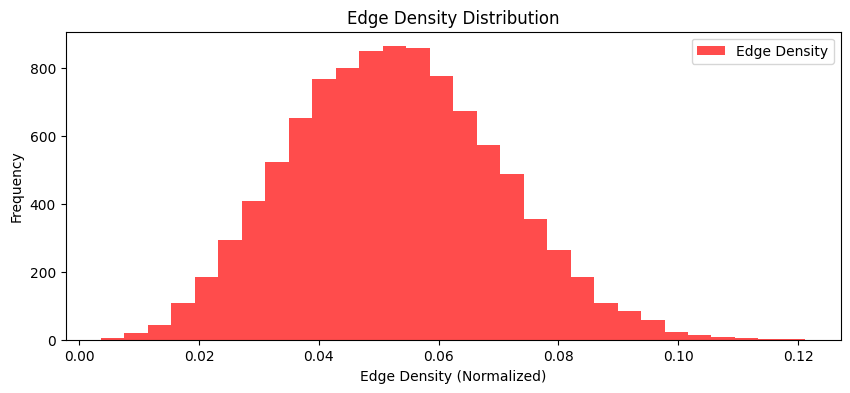

In [25]:
plt.figure(figsize=(10, 4))
plt.hist(edge_densities, bins=30, color='red', alpha=0.7, label='Edge Density')
plt.xlabel("Edge Density (Normalized)")
plt.ylabel("Frequency")
plt.title("Edge Density Distribution")
plt.legend()
plt.show()

In [26]:
def display_sample_images(dataset_path, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    class_labels = ["Indoor", "Outdoor"]

    for i, category in enumerate(os.listdir(dataset_path)):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue

        images = [img for img in os.listdir(category_path)][:num_samples]
        for j, image_name in enumerate(images):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))  # Resize for consistency
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.equalizeHist(gray)  # Apply histogram equalization

            axes[i, j].imshow(gray, cmap="gray")
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{class_labels[i]} {j+1}")

    plt.suptitle("Sample Preprocessed Images from Each Class")
    plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

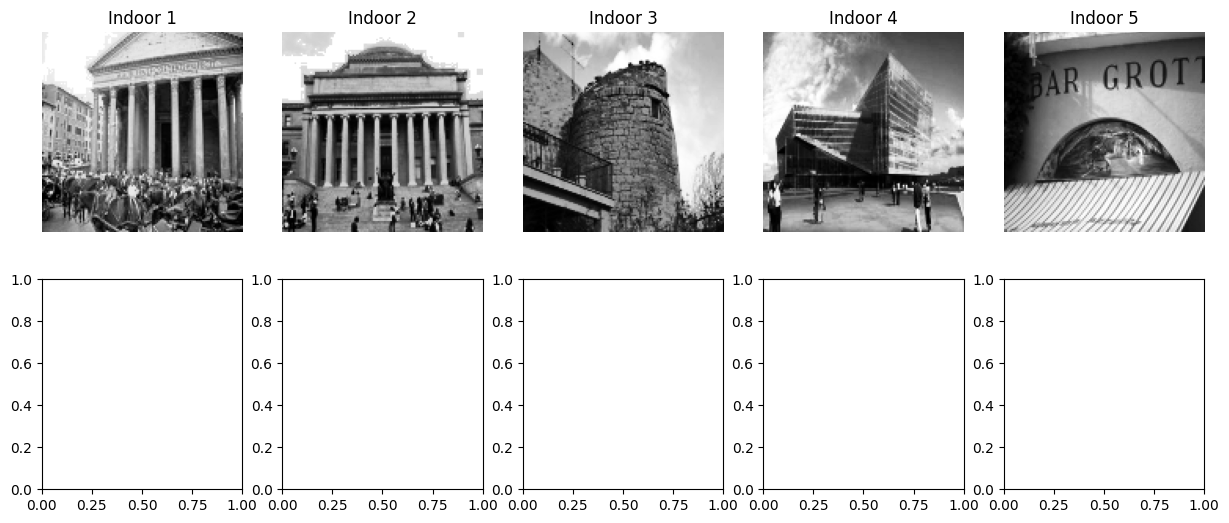

In [27]:
# Call the function to display images
display_sample_images(DATASET_PATH)

In [29]:
# Function: Train and Evaluate Model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n🔹 Results for {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save model
    joblib.dump(model, f"{model_name}.pkl")

In [31]:
# Hyperparameter Tuning Function
def tune_hyperparameters(model, param_grid, X_train, y_train, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

Best parameters for DecisionTree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}

🔹 Results for DecisionTree
Accuracy: 0.8045
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80      1000
           1       0.80      0.81      0.80      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



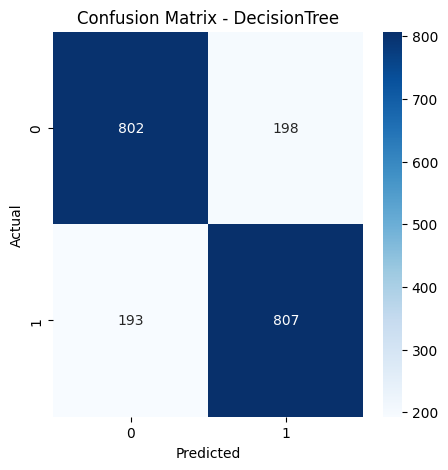

In [33]:
# 1. Train Decision Tree with Hyperparameter Tuning
dt_param_grid = {
    'max_depth': [5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10]
}
best_dt = tune_hyperparameters(DecisionTreeClassifier(random_state=42), dt_param_grid, X_train, y_train, "DecisionTree")
train_and_evaluate_model(best_dt, X_train, y_train, X_test, y_test, "DecisionTree")


Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

🔹 Results for RandomForest
Accuracy: 0.892
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1000
           1       0.90      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



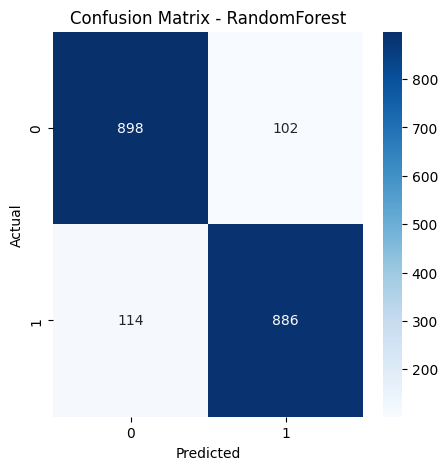

In [34]:
# 2. Train Random Forest with Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
best_rf = tune_hyperparameters(RandomForestClassifier(random_state=42), rf_param_grid, X_train, y_train, "RandomForest")
train_and_evaluate_model(best_rf, X_train, y_train, X_test, y_test, "RandomForest")

In [ ]:
# 3. Train Gradient Boosting with Hyperparameter Tuning
gb_param_grid = {    'n_estimators': [5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 5]
}
best_gb = tune_hyperparameters(GradientBoostingClassifier(random_state=42), gb_param_grid, X_train, y_train, "GradientBoosting")
train_and_evaluate_model(best_gb, X_train, y_train, X_test, y_test, "GradientBoosting")

In [36]:
# 4. Semi-Supervised Learning with Decision Tree
# Select only 20% labeled data, 80% unlabeled
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Train model on labeled data
semi_supervised_dt = DecisionTreeClassifier(max_depth=10, random_state=42)
semi_supervised_dt.fit(X_labeled, y_labeled)

DecisionTreeClassifier(max_depth=10, random_state=42)


🔹 Results for SemiSupervisedDT
Accuracy: 0.971
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       0.98      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



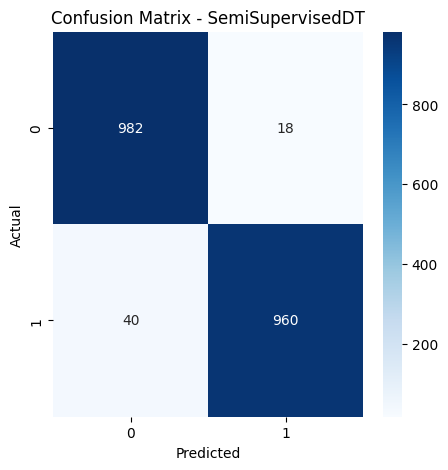

In [37]:
# Predict pseudo-labels for unlabeled data
pseudo_labels = semi_supervised_dt.predict(X_unlabeled)

# Select high-confidence predictions (probability >= 85%)
probabilities = semi_supervised_dt.predict_proba(X_unlabeled)
high_confidence = (probabilities.max(axis=1) >= 0.85)

X_high_confidence = X_unlabeled[high_confidence]
y_high_confidence = pseudo_labels[high_confidence]

# Add high-confidence pseudo-labels to training data
X_new_train = np.vstack((X_labeled, X_high_confidence))
y_new_train = np.hstack((y_labeled, y_high_confidence))

# Retrain model with expanded labeled dataset
semi_supervised_dt.fit(X_new_train, y_new_train)
train_and_evaluate_model(semi_supervised_dt, X_test, y_test, X_test, y_test, "SemiSupervisedDT")